In [97]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import math
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

In [98]:
def standardize_sr(sr, avg, std):
    sr_standardized = sr.apply(lambda x: ((x - avg) / std))
    return sr_standardized

In [99]:
def standardize_train_data(df):
    df_copy = df.copy()
    df_std = df_copy.apply(lambda x: standardize_sr(x, x.mean(), x.std()))
    return pd.DataFrame(df_std)

In [100]:
def standardize_test_data(df, df_train):
    df_copy = df.copy()
    df_std = df_copy.apply(lambda x: standardize_sr(x, df_train[x.name].mean(), df_train[x.name].std()))
    return pd.DataFrame(df_std)

In [101]:
def dist_between_rows(sr_train, sr_test):
    return np.linalg.norm(sr_test - sr_train)

In [102]:
def knn_classifier(train_data, train_target, test_data, test_target):
    positive_count = 0
    negative_count = 0
    test_data_len = len(df_test_data)
    for test_index, test_row in test_data.iterrows():
        minimum_distance = math.inf
        wanted_row_index = 0
        for train_index, train_row in train_data.iterrows():
            distance = dist_between_rows(test_row, train_row)
            if distance < minimum_distance:
                minimum_distance = distance
                wanted_row_index = train_index
        if train_target.loc[wanted_row_index][0] == test_target.loc[test_index][0]:
            positive_count += 1
        else:
            negative_count += 1
    score = (positive_count / (positive_count + negative_count))
    return score

In [103]:
def encode(e_val):
    k = 1
    eigen_sum = e_val.sum()
    while (np.sum(e_val[0:k]) / eigen_sum) < 0.95:
        k += 1
    return k

In [104]:
def covariance(df):
    df_covar_mat = pd.DataFrame(np.dot(df.T, df))
    df_covar_mat /= len(df) - 1
    return np.linalg.eig(df_covar_mat)

In [105]:
def whiten(data):
    u, _, v = np.linalg.svd(data, full_matrices = False)
    return np.dot(u, v)

In [106]:
def pca(data, e_val, e_vec, dimension):
    e_val = e_val.copy()
    e_vec = e_vec.copy()
    indices_l = []
    vectors_l = []
    for i in range(dimension):
        index = e_val.idxmax(axis = 0)[0]
        indices_l.append(index)
        e_val.loc[index] = -math.inf
    for x in indices_l:
        vectors_l.append(e_vec[x].to_numpy())
    df = pd.DataFrame(vectors_l).T
    return np.dot(data, np.transpose(vectors_l))

## All the code given to  us

Test set score of 1-nn: 0.46


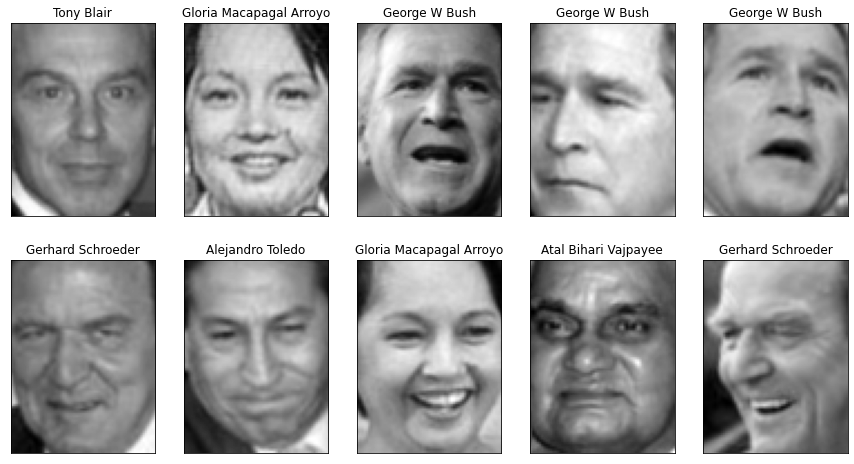

In [107]:
people = fetch_lfw_people(min_faces_per_person=20, resize=.7)
image_shape = people.images[0].shape
fig, axes = plt.subplots(2, 5, figsize=(15,8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap=cm.gray)
    ax.set_title(people.target_names[target])
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
x_people = people.data[mask]
y_people = people.target[mask]
x_people = x_people / 255
x_train, x_test, y_train, y_test = train_test_split(x_people, y_people, stratify = y_people, random_state=0)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(x_test, y_test)))

## My KNN Solution

In [108]:
df_train_data = pd.DataFrame(x_train)
df_test_data = pd.DataFrame(x_test)
df_train_target = pd.DataFrame(y_train)
df_test_target = pd.DataFrame(y_test)

In [109]:
knn_score = knn_classifier(df_train_data, df_train_target, df_test_data, df_test_target)

In [110]:
knn_score

0.463768115942029

## 100 Dimension PCA

In [111]:
df_data = pd.DataFrame(x_people)

In [112]:
df_data_std = standardize_train_data(df_data)

In [113]:
eig_val, eig_vec = covariance(df_data_std)

In [114]:
df_eig_val = pd.DataFrame(eig_val)
df_eig_vec = pd.DataFrame(eig_vec)

In [115]:
hundred_dim_mat = pca(df_data_std, df_eig_val, df_eig_vec, 100)

In [116]:
df_hundred_dim_data = pd.DataFrame(hundred_dim_mat)

In [117]:
hundred_dim_x_train, hundred_dim_x_test, hundred_dim_y_train, hundred_dim_y_test = train_test_split(hundred_dim_mat, y_people, stratify = y_people, random_state=0)

In [118]:
df_hundred_dim_train_data = pd.DataFrame(hundred_dim_x_train)
df_hundred_dim_test_data = pd.DataFrame(hundred_dim_x_test)
df_hundred_dim_train_target = pd.DataFrame(hundred_dim_y_train)
df_hundred_dim_test_target = pd.DataFrame(hundred_dim_y_test)

In [119]:
hundred_dim_knn_score = knn_classifier(df_hundred_dim_train_data, df_hundred_dim_train_target, df_hundred_dim_test_data, df_hundred_dim_test_target)

In [120]:
hundred_dim_knn_score

0.45652173913043476

## 100 Dimension Whitened Data

In [121]:
hundred_dim_whitened_train_data = whiten(df_hundred_dim_train_data)
hundred_dim_whitened_test_data = whiten(df_hundred_dim_test_data)

In [122]:
_, _, hundred_dim_whitened_train_target, hundred_dim_whitened_test_target = train_test_split(hundred_dim_mat, y_people, stratify = y_people, random_state=0)

In [123]:
df_hundred_dim_whitened_train_data = pd.DataFrame(hundred_dim_whitened_train_data)
df_hundred_dim_whitened_test_data = pd.DataFrame(hundred_dim_whitened_test_data)
df_hundred_dim_whitened_train_target = pd.DataFrame(hundred_dim_whitened_train_target)
df_hundred_dim_whitened_test_target = pd.DataFrame(hundred_dim_whitened_test_target)

In [124]:
hundred_dim_whitened_score = knn_classifier(df_hundred_dim_whitened_train_data, df_hundred_dim_whitened_train_target, df_hundred_dim_whitened_test_data, df_hundred_dim_whitened_test_target)

In [125]:
hundred_dim_whitened_score

0.5579710144927537

## 2 Dimension

In [126]:
two_dim_eig_val, two_dim_eig_vec = covariance(df_data_std)

In [127]:
two_dim_data = pca(df_data_std, pd.DataFrame(two_dim_eig_val), pd.DataFrame(two_dim_eig_vec), 2)

In [128]:
df_two_dim_data = pd.DataFrame(two_dim_data)

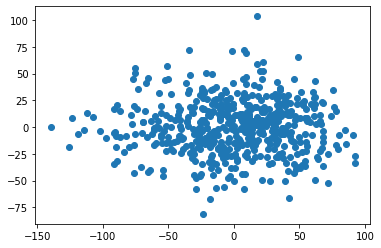

In [129]:
plt.scatter(df_two_dim_data[0], df_two_dim_data[1])
plt.show()

# Eigenfaces

In [130]:
PC1 = df_eig_vec.astype(np.float64)[0]
PC2 = df_eig_vec.astype(np.float64)[1]

In [131]:
stdev = pd.DataFrame(x_people).std().to_numpy()
average = pd.DataFrame(x_people).mean().to_numpy()

## PC1 Min Max

In [132]:
PC1_dot_prod = np.dot(x_test, PC1)
sr_PC1_dot_prod = pd.Series(PC1_dot_prod)

PC1_max_index = sr_PC1_dot_prod.idxmax()
PC1_max_val_pic = y_test[PC1_max_index]

PC1_min_index = sr_PC1_dot_prod.idxmin()
PC1_min_val_pic = df_test_target.loc[PC1_min_index].to_numpy()

### PC1 - Maximum Value

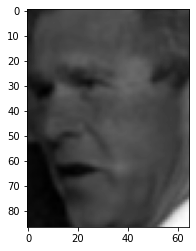

In [133]:
PC1_max = np.dot(df_test_data.loc[PC1_max_val_pic].to_numpy(), np.dot(PC1_dot_prod, PC1_dot_prod.transpose()))
PC1_max_res = (PC1_max * stdev) + average
plt.gray()
plt.imshow(PC1_max_res.reshape(87, 65))

### PC1 - Minimum Value

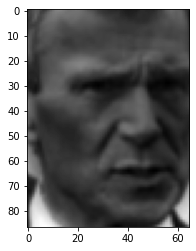

In [134]:
PC1_min = np.dot(df_test_data.loc[PC1_min_val_pic].to_numpy(), np.dot(PC1_dot_prod, PC1_dot_prod.transpose()))
PC1_min_res = (PC1_min * stdev) + average
plt.imshow(PC1_min_res.reshape(87, 65))

## PC2 Min Max

In [145]:
PC2_dot_prod = np.dot(x_test, PC2)
sr_PC2_dot_prod = pd.Series(PC2_dot_prod)

PC2_max_index = sr_PC2_dot_prod.idxmax()
PC2_max_val_pic = df_test_target.loc[PC2_max_index].to_numpy()

PC2_min_index = sr_PC2_dot_prod.idxmin()
PC2_min_val_pic = df_test_target.loc[PC2_min_index].to_numpy()

### PC2 Maximum Value

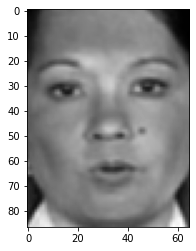

In [146]:
PC2_max = np.dot(df_test_data.loc[PC2_max_val_pic].to_numpy(), np.dot(PC2_dot_prod, PC2_dot_prod.transpose()))
PC2_max_res = (PC2_max * stdev) + average
plt.imshow(PC2_max_res.reshape(87, 65))

### PC2 Minimum Value

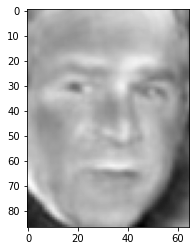

In [147]:
PC2_min = np.dot(df_test_data.loc[PC2_min_val_pic].to_numpy(), np.dot(PC2_dot_prod, PC2_dot_prod.transpose()))
PC2_min_res = (PC2_min * stdev) + average
plt.imshow(PC2_min_res.reshape(87, 65))

### Principle Eigenface

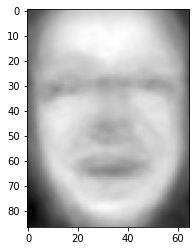

In [148]:
plt.imshow(PC1.to_numpy().reshape(87,65))

### Principle Reconstruction

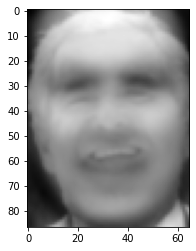

In [149]:
principle_reconst = np.dot(df_train_data.loc[0].to_numpy(), np.dot(PC1.to_numpy(), PC1.to_numpy().transpose()))
final_res = (principle_reconst * stdev) + average
plt.gray()
plt.imshow(final_res.reshape(87, 65))

### 95% Reconstruction

In [150]:
res = encode(eig_val.astype(np.float64))

In [151]:
res

134

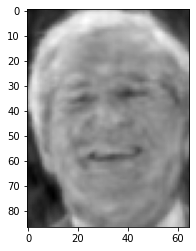

In [152]:
subsection =  eig_vec.astype(np.float64)[:, :res]
projection = np.dot(df_train_data.loc[0].to_numpy(), np.dot(subsection, subsection.transpose()))
plt.imshow(projection.reshape(87,65))